In [1]:
import numpy as np
import pandas as pd
from epiweeks import Week
from itertools import product
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec

In [2]:
def transform_label(ep_label): 
    year_ep_label = int(ep_label[:4])
    week_ep_label = int(ep_label[4:])
    
    if week_ep_label <=40:
        new_week = 12 + week_ep_label
        new_year = year_ep_label
    
    else:
        new_week = week_ep_label - 40
        new_year = year_ep_label +1
    
    if new_week <=9:
        week_str = f'0{new_week}'
    else:
        week_str = str(new_week)

    new_ep_label = f'{new_year}{week_str}'

    return new_ep_label

In [3]:
state = 'MG'

In [4]:
df = pd.read_csv('./data/dengue.csv.gz')

df = df.loc[df.uf == state] 

df.date = pd.to_datetime(df.date)

df.set_index('date', inplace = True)

df.head()

,year,epiweek,casos,geocode,regional,regional_geocode,macroregional,macroregional_geocode,uf,train_1,train_2,target_1,target_2
date,,,,,,,,,,,,,
2010-01-03,2010,201001,0,3110806,Itambacuri,31096,Nordeste,3111,MG,True,True,False,False
2010-01-03,2010,201001,0,3132404,Itajubá,31003,Sul,3101,MG,True,True,False,False
2010-01-03,2010,201001,0,3168903,São Gotardo,31082,Noroeste,3109,MG,True,True,False,False
2010-01-03,2010,201001,0,3155405,Juiz de Fora,31097,Sudeste,3107,MG,True,True,False,False
2010-01-03,2010,201001,0,3170602,Piumhi,31093,Sul,3101,MG,True,True,False,False


In [5]:
def agg_data(df, geocode = None):

    if geocode is not None: 

        df = df.loc[df.geocode == geocode]
        
    df_w = df[['casos']]

    df_w = df_w.resample('W-SUN').sum()
    
    df_w['epiweek_label'] = [Week.fromdate(x) for x in df_w.index]
    
    df_w['epiweek_label'] = df_w['epiweek_label'].astype(str)
    
    df_w['epiweek_label'] = df_w['epiweek_label'].apply(transform_label)
    
    
    df_w['epiweek'] = df_w['epiweek_label'].astype(str).str[-2:].astype(int)
    df_w['year'] = df_w['epiweek_label'].astype(str).str[:4].astype(int)
    
    df_w['casos_totais'] = pd.NA
    
    for year in df_w.year.unique():
    
        df_w.loc[df_w.year == year, 'casos_totais'] = df_w.loc[(df_w.year == year)].casos.sum()
    
    return df_w
        

In [6]:
df_w = agg_data(df)
df_w.head()

,casos,epiweek_label,epiweek,year,casos_totais
date,,,,,
2010-01-03,2794,201013,13,2010,258066
2010-01-10,3729,201014,14,2010,258066
2010-01-17,4656,201015,15,2010,258066
2010-01-24,6195,201016,16,2010,258066
2010-01-31,7179,201017,17,2010,258066


In [7]:
def get_train_data(df_w_train): 

    columns_to_normalize = ['casos', 'epiweek', 'casos_totais']

    norm_values = df_w_train.max()[columns_to_normalize]
    

    df_w_train[['casos', 'epiweek', 'casos_totais']] = df_w_train[['casos', 'epiweek', 'casos_totais']]/norm_values
    
    min_year = df_w_train.index.year.min() + 2

    if min_year <=2012:
        min_year = 2013

    X_train = np.empty((0, 2, 3))
    
    y_train = np.empty((0, 1))
        
    for year, week in product(np.arange(min_year, df_w_train.index.year.max()), np.arange(1,53)): 
        
        if week <=9:
            week_str = f'0{week}'
        else:
            week_str = str(week)
        try:
            last_2 = np.array([df_w_train.loc[(df_w_train.epiweek_label == f'{year-2}{week_str}')][['epiweek', 'casos', 'casos_totais']].values[0]]).reshape(1, 1,-1)
        
            last_1 = np.array([df_w_train.loc[(df_w_train.epiweek_label == f'{year-1}{week_str}')][['epiweek', 'casos', 'casos_totais']].values[0]]).reshape(1, 1,-1)
        
            last_values = np.array(np.append(last_2, last_1, axis=1))
                
            X_train = np.append(X_train, last_values, axis = 0)
        
            y_train = np.append(y_train, np.array([df_w_train.loc[(df_w_train.epiweek_label == f'{year}{week_str}')][['casos']].values[0]]).reshape(1,-1),
                               axis = 0)

        except:
            print(year)
            print(week)
            pass 
            

    return X_train.astype(np.float32), y_train.astype(np.float32), norm_values 


def get_test_data(norm_values, df_w_test):
    '''
    Essa função gera os dados de teste apenas para uma ano específico. 
    '''

    norm_values = norm_values[['casos', 'epiweek', 'casos_totais']]

    df_w_test[['casos', 'epiweek', 'casos_totais']] = df_w_test[['casos', 'epiweek', 'casos_totais']]/norm_values

    year  = df_w_test.index.year.max()

    X_test = np.empty((0, 2, 3))
    
    y_test = np.empty((0, 1))
        
    for week in np.arange(1,53):

        if week <=9:
            week_str = f'0{week}'
        else:
            week_str = str(week)
            
        try:
            last_2 = np.array([df_w_test.loc[(df_w_test.epiweek_label == f'{year-2}{week_str}')][['epiweek', 'casos', 'casos_totais']].values[0]]).reshape(1, 1,-1)
            
            last_1 = np.array([df_w_test.loc[(df_w_test.epiweek_label == f'{year-1}{week_str}')][['epiweek', 'casos', 'casos_totais']].values[0]]).reshape(1, 1,-1)
            
            last_values = np.array(np.append(last_2, last_1, axis=1))
                    
            X_test = np.append(X_test, last_values, axis = 0)
            
            y_test = np.append(y_test, np.array([df_w_test.loc[(df_w_test.epiweek_label == f'{year}{week_str}')][['casos']].values[0]]).reshape(1,-1),
                                   axis = 0)
        except: 
            pass

    return X_test.astype(np.float32), y_test.astype(np.float32)
    

In [8]:
from time import time
import tensorflow as tf
from keras import layers
import keras.backend as K
import tensorflow.keras as keras
from tensorflow.keras.layers import LSTM, Attention, Dense, Dropout, Bidirectional, Flatten, Conv1D, Concatenate #, ConvLSTM1D, TimeDistributed
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, explained_variance_score, mean_squared_error, mean_squared_log_error, \
    median_absolute_error, r2_score
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, LearningRateScheduler
from tensorflow.keras.activations import gelu 
from keras.optimizers import Adam#, RMSprop

In [9]:
def make_preds(model, X_test, dates):

    predicted = np.stack([model(X_test, training =True) for i in range(100)], axis=2)

    df_pred = pd.DataFrame(np.percentile(predicted, 50, axis=2))
    df_pred25 = pd.DataFrame(np.percentile(predicted, 2.5, axis=2))
    df_pred975 = pd.DataFrame(np.percentile(predicted, 97.5, axis=2))
    
    df_preds = pd.concat([ df_pred25.rename(columns = {0: 'lower'}), df_pred.rename(columns = {0: 'preds'}), df_pred975.rename(columns = {0: 'upper'}) ] , axis = 1)

    df_preds['dates'] = pd.to_datetime(dates)

    return df_preds[['dates', 'lower', 'preds', 'upper']]

In [10]:
X_train, y_train, norm_values = get_train_data(df_w.loc[df_w.year < 2023])

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_25933/736416443.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w_train[['casos', 'epiweek', 'casos_totais']] = df_w_train[['casos', 'epiweek', 'casos_totais']]/norm_values


In [11]:
X_test, y_test = get_test_data(norm_values, df_w.loc[df_w.year <= 2023])

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_25933/736416443.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w_test[['casos', 'epiweek', 'casos_totais']] = df_w_test[['casos', 'epiweek', 'casos_totais']]/norm_values


In [12]:
from tensorflow.keras.models import load_model

# Load the model
model_base = load_model('models/base_dengue_MG_2023.keras')

df_preds_base = make_preds(model_base, X_test, dates = df_w.loc[df_w.year == 2023].index.values)

model_global = load_model('models/global_dengue_MG_2023.keras')

df_preds_global = make_preds(model_global, X_test, dates = df_w.loc[df_w.year == 2023].index.values)


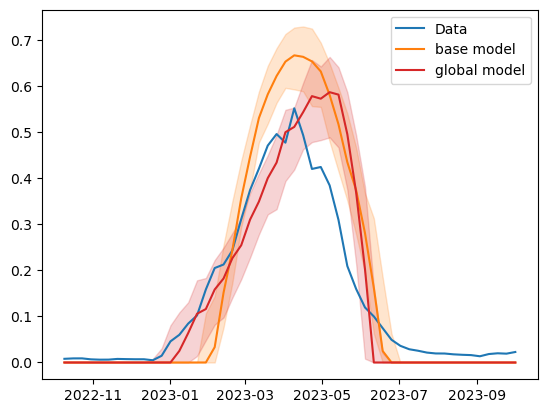

In [16]:
fig, ax = plt.subplots()

ax.plot(df_preds_base.dates, y_test, label = 'Data')

ax.plot(df_preds_base.dates, df_preds_base.preds, label = 'base model', color = 'tab:orange')

ax.fill_between(df_preds_base.dates, df_preds_base.lower, df_preds_base.upper, color = 'tab:orange', alpha = 0.2)

ax.plot(df_preds_base.dates, df_preds_global.preds, label = 'global model', color = 'tab:red')

ax.fill_between(df_preds_global.dates, df_preds_global.lower, df_preds_global.upper, color = 'tab:red', alpha = 0.2)

ax.legend()

plt.show()